# GARCH Model -> volatility 결측치 처리

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
# fig
figsize=(15,5)

import seaborn as sns
import matplotlib.dates as mdates
import arch
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import itertools
import warnings
import arch
# 경고 메시지 무시
warnings.filterwarnings("ignore")

import itertools

In [12]:
df = pd.read_csv('BIT_2023_1차.csv')
df.head(3)

,time,Open,High,Low,Close,Volume,returns,volatility,price,quote_qty,is_buyer_maker,quote_qty_cal
0,2023-01-01 0:00,16537.5,16540.9,16504.0,16527.0,5381.399,NaN,NaN,16524.52574,7264.129209,16494,88925066.30
1,2023-01-01 1:00,16527.1,16554.3,16524.1,16550.4,3210.826,0.001416,NaN,16537.21599,6819.889969,8705,53098123.05
2,2023-01-01 2:00,16550.5,16557.1,16534.8,16542.4,2399.668,-0.000483,NaN,16545.81814,6030.420093,8468,39704470.32


In [13]:
df.set_index('time', inplace=True)
df.index=pd.to_datetime(df.index)

In [14]:
dfc = df.copy()

In [15]:
# 결측치인 행의 time 추출
missing_time = df.loc[df['volatility'].isna()].index

# 결과 출력
print(missing_time)

DatetimeIndex(['2023-01-01 00:00:00', '2023-01-01 01:00:00',
               '2023-01-01 02:00:00', '2023-01-01 03:00:00',
               '2023-01-01 04:00:00', '2023-01-01 05:00:00',
               '2023-01-01 06:00:00', '2023-01-01 07:00:00',
               '2023-01-01 08:00:00', '2023-01-01 09:00:00',
               ...
               '2023-12-01 10:00:00', '2023-12-01 11:00:00',
               '2023-12-01 12:00:00', '2023-12-01 13:00:00',
               '2023-12-01 14:00:00', '2023-12-01 15:00:00',
               '2023-12-01 16:00:00', '2023-12-01 17:00:00',
               '2023-12-01 18:00:00', '2023-12-01 19:00:00'],
              dtype='datetime64[ns]', name='time', length=186, freq=None)


# GARCH 모델

<hr>

# *보간 코드 함수화

In [16]:
def interpolate_missing_values(df, column):
    
    # 결측치 보간
    returns = df[column]
    interpolated_returns = returns.interpolate(method='linear')
    df[column] = interpolated_returns

    # 결측치 인덱스 추출
    missing_indices = returns[returns.isna()].index

    # 결측치 이전까지의 데이터 사용 - GARCH 모델 적합
    model = arch.arch_model(returns.dropna(), vol='Garch', p=1, q=1)
    model_fit = model.fit()

    # 결측치 예측
    forecasted_values = model_fit.forecast(start=missing_indices[0], horizon=len(missing_indices))

    # 예측값 -> 결측치 위치에 대입해 보간
    predicted_values = forecasted_values.mean.iloc[-1].values
    returns.loc[missing_indices] = predicted_values

    return df

# 'volatility' 컬럼의 결측치 보간
df = interpolate_missing_values(df, 'volatility')

Iteration:      1,   Func. Count:      5,   Neg. LLF: -43288.10796413225
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -43288.10804759927
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1


C:\Users\jwoo\anaconda3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


<hr>

In [17]:
dfc['volatility'].isna().sum() # 결측치 처리 전

186

In [18]:
df['volatility'].isna().sum() # 결측치 처리 후

0

- 결측치 0개 확인

# 2. 모델 생성 & 1. 최적화

<hr>

# *최적화 & 모델 생성 코드 함수화

In [20]:
# 최적의 p,q 찾기 함수
def find_optimal_pq(returns):
    # 데이터 및 모델 정의
    best_aic = float("inf")
    best_bic = float("inf")
    best_p = 0
    best_q = 0
    
    # p와 q의 후보값 설정
    p_values = range(0, 5)  # p의 후보값 (0~4)
    q_values = range(0, 5)  # q의 후보값 (0~4)

    # 그리드 탐색
    for p, q in itertools.product(p_values, q_values):
        try:
            model = arch.arch_model(returns, vol="Garch", p=p, q=q)
            model_fit = model.fit(disp="off")
            aic = model_fit.aic
            bic = model_fit.bic
            if aic < best_aic:
                best_aic = aic
                best_p = p
                best_q = q
            if bic < best_bic:
                best_bic = bic
                best_p = p
                best_q = q
        except:
            continue

    # 최적의 p와 q 값 출력
    print("AIC를 기준으로 최적의 p와 q 값:", best_p, best_q)
    print("BIC를 기준으로 최적의 p와 q 값:", best_p, best_q)
    print('\n')
    
    return best_p, best_q

In [21]:
# GARCH 모델 생성 및 최적화 함수
def simulate_garch_model(returns, p, q):
    # GARCH 모델 생성 및 최적화
    model = arch.arch_model(returns, vol='Garch', p=p, q=q)
    model_fit = model.fit()

    # 모델 시뮬레이션
    nobs = len(returns)
    simulated_data = model_fit.conditional_volatility[-nobs:] * np.random.normal(0, 1, nobs)

    return simulated_data

In [22]:
# 사용 예시
best_p, best_q = find_optimal_pq(returns)
simulated_data = simulate_garch_model(returns, best_p, best_q)
print(simulated_data)

C:\Users\jwoo\anaconda3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\jwoo\anaconda3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\jwoo\anaconda3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\jwoo\anaconda3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\jwoo\anaconda3\lib\site-package

AIC를 기준으로 최적의 p와 q 값: 1 1
BIC를 기준으로 최적의 p와 q 값: 1 1


Iteration:      1,   Func. Count:      5,   Neg. LLF: -44366.9328469573
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -44366.93292988197
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
time
2023-01-01 00:00:00    0.001100
2023-01-01 01:00:00   -0.001227
2023-01-01 02:00:00    0.000240
2023-01-01 03:00:00    0.000162
2023-01-01 04:00:00   -0.000264
                         ...   
2023-12-31 19:00:00    0.000567
2023-12-31 20:00:00    0.000581
2023-12-31 21:00:00   -0.001655
2023-12-31 22:00:00   -0.002494
2023-12-31 23:00:00   -0.001048
Name: cond_vol, Length: 8760, dtype: float64


C:\Users\jwoo\anaconda3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\jwoo\anaconda3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\jwoo\anaconda3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\jwoo\anaconda3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\jwoo\anaconda3\lib\site-package

<hr>

# 3. 시각화 코드

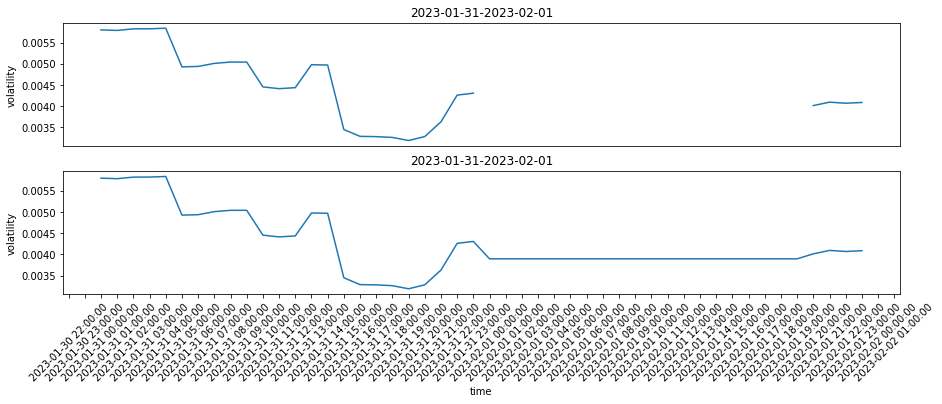

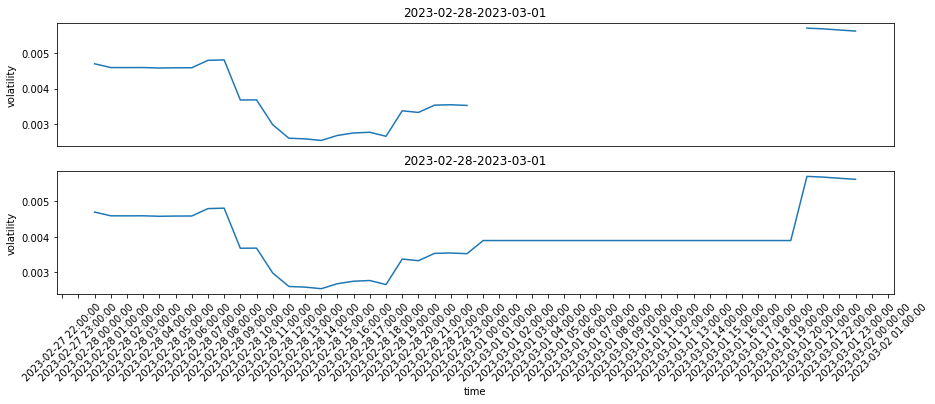

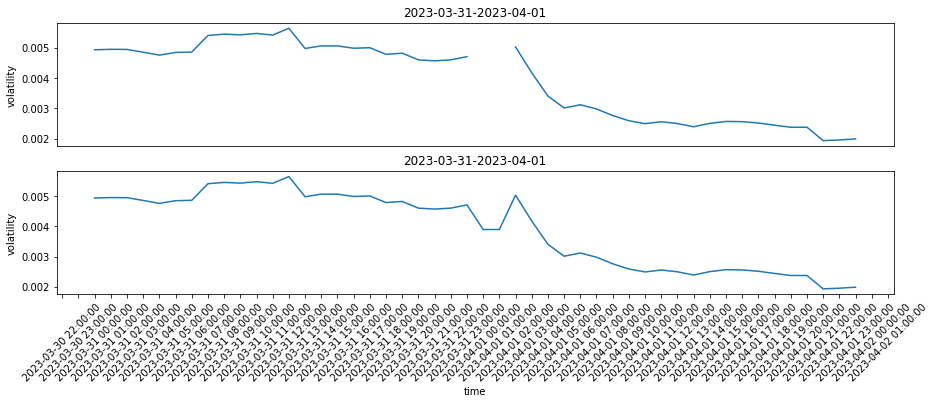

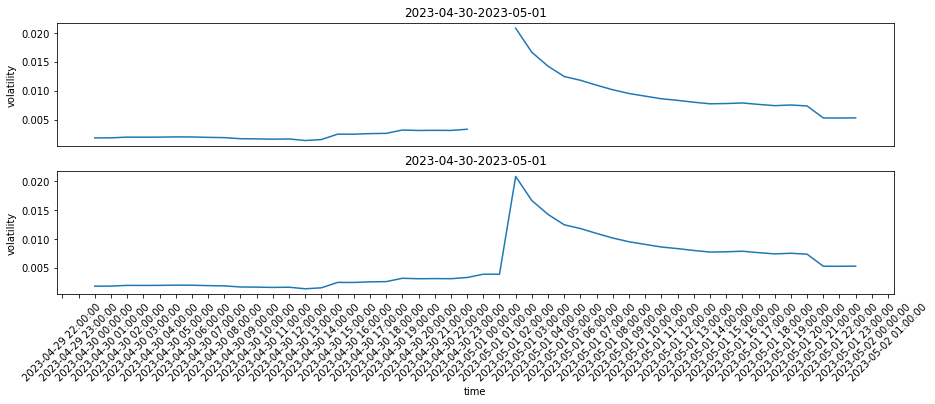

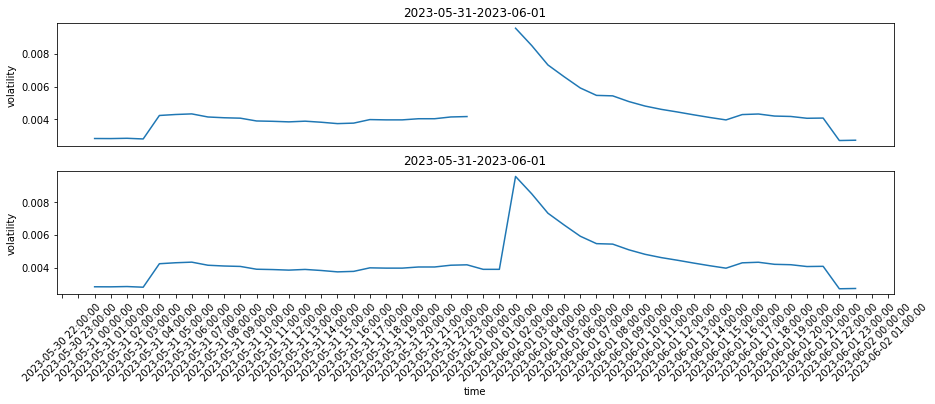

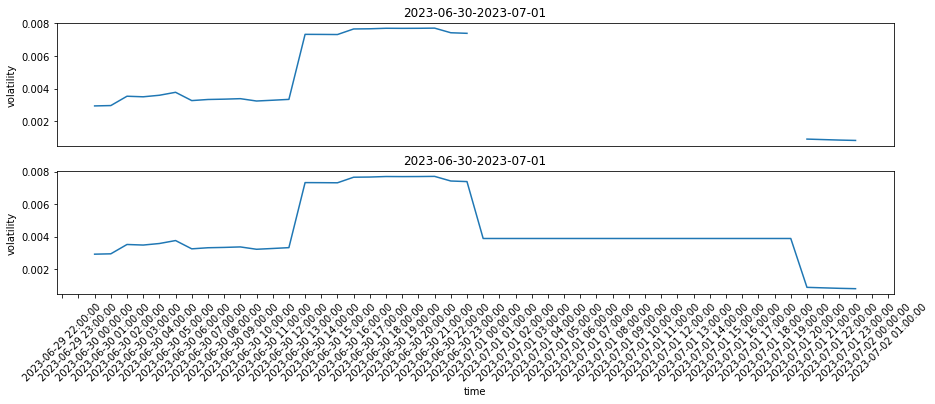

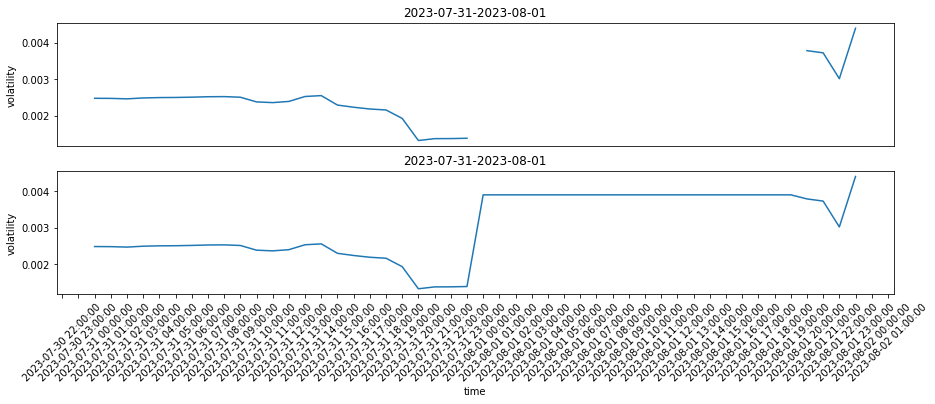

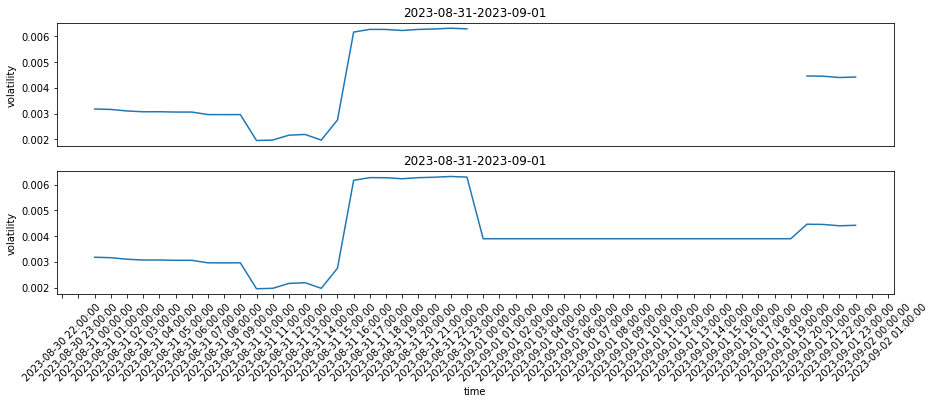

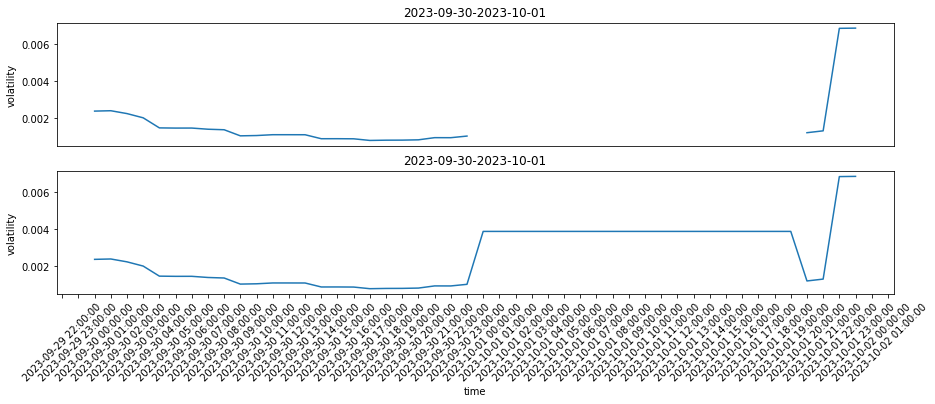

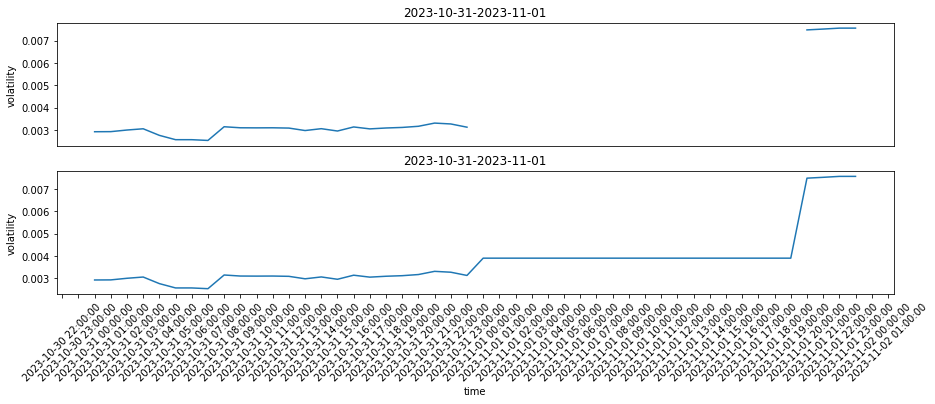

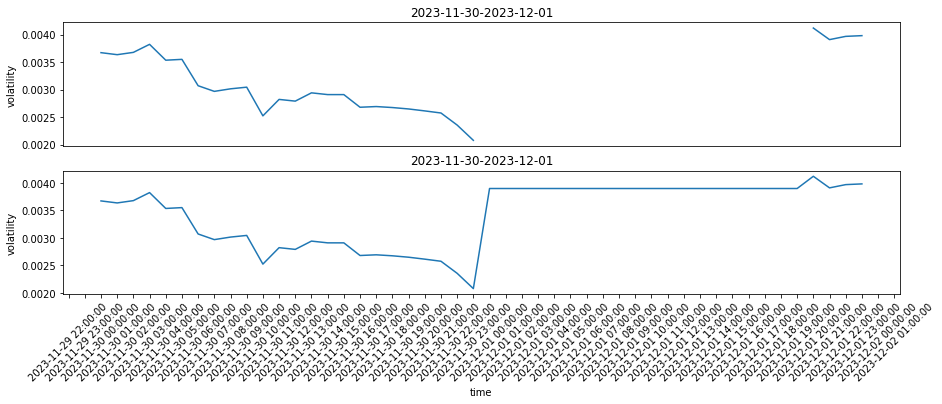

In [23]:
def Visualizing_returns(dfc, df, start_date, end_date, figsize=(15,5)):
    
    dfc_filtered = dfc.loc[start_date:end_date]
    df_filtered = df.loc[start_date:end_date]
    
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=figsize)
    
    ax[0].plot(dfc_filtered.index, dfc_filtered)
    ax[0].set_ylabel('volatility')
    ax[0].set_title(f'{start_date}-{end_date}')
    ax[0].set_xticks([])

    ax[1].plot(df_filtered.index, df_filtered)
    ax[1].set_xlabel('time')
    ax[1].set_ylabel('volatility')
    ax[1].set_title(f'{start_date}-{end_date}')
    
    ax[1].xaxis.set_major_locator(mdates.HourLocator())
    ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
    ax[1].tick_params(axis='x', rotation=45)
    
    plt.show()
    
Visualizing_returns(dfc['volatility'], df['volatility'],'2023-01-31', '2023-02-01')
Visualizing_returns(dfc['volatility'], df['volatility'], '2023-02-28', '2023-03-01')
Visualizing_returns(dfc['volatility'], df['volatility'], '2023-03-31', '2023-04-01')
Visualizing_returns(dfc['volatility'], df['volatility'], '2023-04-30', '2023-05-01')
Visualizing_returns(dfc['volatility'], df['volatility'], '2023-05-31', '2023-06-01')
Visualizing_returns(dfc['volatility'], df['volatility'], '2023-06-30', '2023-07-01')
Visualizing_returns(dfc['volatility'], df['volatility'], '2023-07-31', '2023-08-01')
Visualizing_returns(dfc['volatility'], df['volatility'], '2023-08-31', '2023-09-01')
Visualizing_returns(dfc['volatility'], df['volatility'], '2023-09-30', '2023-10-01')
Visualizing_returns(dfc['volatility'], df['volatility'], '2023-10-31', '2023-11-01')
Visualizing_returns(dfc['volatility'], df['volatility'], '2023-11-30', '2023-12-01')